In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import random
from config import POSTGRES_CONNECTION_STRING
from sqlalchemy import create_engine
import json

In [2]:
def con():
    return create_engine(POSTGRES_CONNECTION_STRING)

In [3]:
borders = np.load('map-borders.npy')
borders

array([[55.1471993 , 36.75571401],
       [56.0785417 , 38.06930099]])

In [4]:
sportzones = pd.read_sql_query('''
    select *
    from sportzones
''', con())
print(sportzones.shape[0])
sportzones.head()

26238


,id,name,sportzone_type_id,object_id,square
0,1042887,зал тренажерный,34,119418,569.5
1,1042886,зал спортивный,32,119418,216.0
2,1042888,площадка для игры в баскетбол,64,119418,216.0
3,1042889,универсальная спортивная площадка,104,119418,180.0
4,1042890,площадка для игры в волейбол,65,119418,180.0


In [5]:
%%time
parts32 = pd.read_sql_query('''
    select *
    from sportzone_density_matrixes
    where size = 32
''', con())

CPU times: user 162 ms, sys: 42.5 ms, total: 204 ms
Wall time: 726 ms


In [6]:
%%time
map32 = np.zeros((32, 32))
for _, part in parts32.iterrows():
    vert_index = part['vert_index']
    horz_index = part['horz_index']
    height = part['height']
    width = part['width']
    matrix = json.loads(part['matrix'])
    for i in range(height):
        for j in range(width):
            map32[i + vert_index, j + horz_index] += matrix[i][j]

CPU times: user 584 ms, sys: 0 ns, total: 584 ms
Wall time: 583 ms


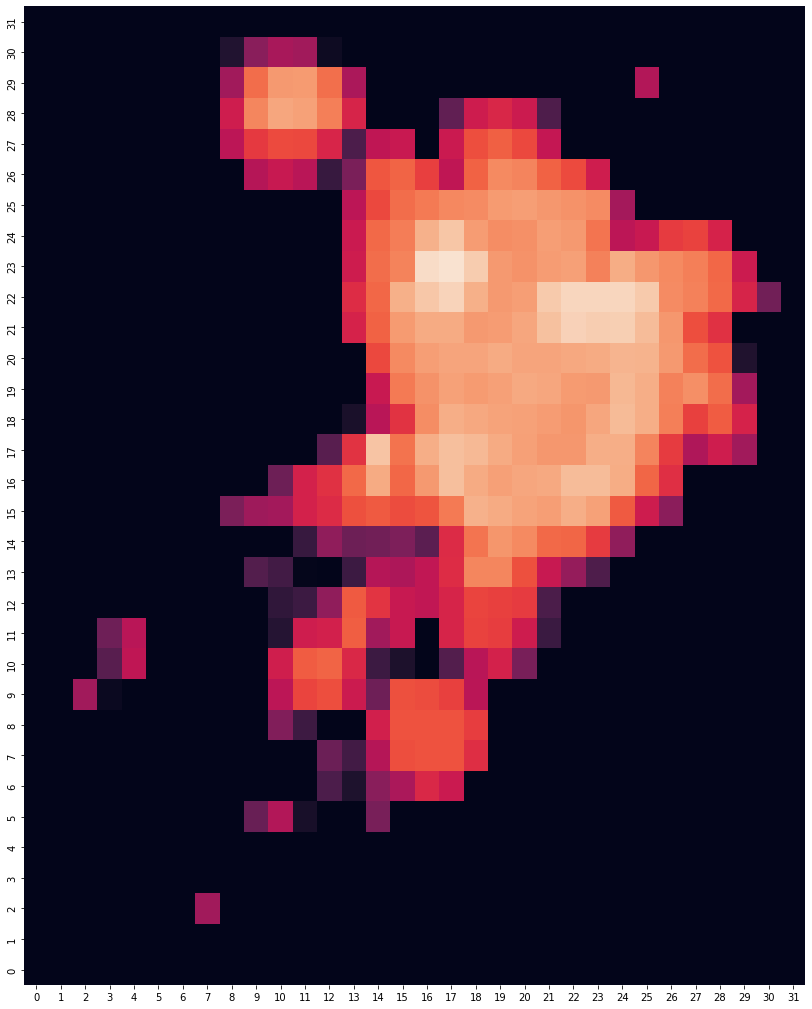

In [7]:
plt.figure(figsize=(14, 18))
sns.heatmap(np.log1p(map32), cbar=False, vmin=0, vmax=14)
plt.gca().invert_yaxis()
plt.show()

In [8]:
def plot_sportzones(ids):
    parts32 = pd.read_sql_query('''
        select *
        from sportzone_density_matrixes
        where size = 32
            and sportzone_id in %(ids)s
    ''', con(), params={'ids': tuple(ids)})
    map32 = np.zeros((32, 32))
    for _, part in parts32.iterrows():
        vert_index = part['vert_index']
        horz_index = part['horz_index']
        height = part['height']
        width = part['width']
        matrix = json.loads(part['matrix'])
        for i in range(height):
            for j in range(width):
                map32[i + vert_index, j + horz_index] += matrix[i][j]
    return map32

In [9]:
%%time
map32 = plot_sportzones(sportzones.sample(frac=1)['id'])

CPU times: user 752 ms, sys: 50.8 ms, total: 802 ms
Wall time: 1.53 s


In [10]:
def select_zoom_level(borders, min_lat, min_lng, max_lat, max_lng):
    zoom_lat = (borders[1][0] - borders[0][0]) / (max_lat - min_lat)
    zoom_lng = (borders[1][1] - borders[0][1]) / (max_lng - min_lng)
    zoom = max(zoom_lat, zoom_lng)
    power_of_2 = int(np.log2(zoom) + 5.5)
    size = 2 ** power_of_2
    size = max(min(2048, size), 32)
    return size

def get_covered_index(x, left, right, steps):
    length = right - left
    shift = x - left
    step_size = length / steps
    relative_position = shift / length
    index = math.floor(relative_position * steps)
    return index

def get_sportzone_heatmap(selection, ids, borders, connection):
    (lat_min, lng_min), (lat_max, lng_max) = borders
    (sel_lat_min, sel_lng_min), (sel_lat_max, sel_lng_max) = selection
    if sel_lat_min > sel_lat_max or sel_lng_min > sel_lng_max:
        raise Exception('Selection must be sorted (min_lat, min_lng), (max_lat, max_lng)')
    size = select_zoom_level(borders, sel_lat_min, sel_lng_min, sel_lat_max, sel_lng_max)
    lat_n = size
    lng_n = size
    lat_step = (lat_max - lat_min) / lat_n
    lng_step = (lng_max - lng_min) / lng_n
    
    sel_vert_index_min = min(max(get_covered_index(sel_lat_min, lat_min, lat_max, lat_n), 0), lat_n - 1)
    sel_horz_index_min = min(max(get_covered_index(sel_lng_min, lng_min, lng_max, lng_n), 0), lng_n - 1)
    sel_vert_index_max = min(max(get_covered_index(sel_lat_max, lat_min, lat_max, lat_n), 0), lat_n - 1)
    sel_horz_index_max = min(max(get_covered_index(sel_lng_max, lng_min, lng_max, lng_n), 0), lng_n - 1)
    
    result_borders = (
        (
            lat_min + lat_step * sel_vert_index_min,
            lng_min + lng_step * sel_horz_index_min
        ), (
            lat_min + lat_step * (sel_vert_index_max + 1),
            lng_min + lng_step * (sel_horz_index_max + 1)
        )
    )
    result_shape = (
        sel_vert_index_max - sel_vert_index_min + 1,
        sel_horz_index_max - sel_horz_index_min + 1
    )
    
    parts = pd.read_sql_query('''
        SELECT vert_index, horz_index, height, width, matrix
        FROM sportzone_density_matrixes
        WHERE vert_index + height - 1 >= %(vert_index_min)s
          AND vert_index - height + 1 <= %(vert_index_max)s
          AND horz_index + width - 1 >= %(horz_index_min)s
          AND horz_index - width + 1 <= %(horz_index_max)s
          AND sportzone_id in %(ids)s
    ''', params={
        'vert_index_min': sel_vert_index_min,
        'vert_index_max': sel_vert_index_max,
        'horz_index_min': sel_horz_index_min,
        'horz_index_max': sel_horz_index_max,
        'ids': tuple(ids)
    }, con=connection)
    result_matrix = np.zeros(result_shape)
    for _, part in parts.iterrows():
        vert_index = part['vert_index']
        horz_index = part['horz_index']
        height = part['height']
        width = part['width']
        copy_vert_index_min = max(sel_vert_index_min, vert_index)
        copy_vert_index_max = min(sel_vert_index_max, vert_index + height - 1)
        copy_horz_index_min = max(sel_horz_index_min, horz_index)
        copy_horz_index_max = min(sel_horz_index_max, horz_index + width - 1)
        matrix = json.loads(part['matrix'])
        for i in range(copy_vert_index_min, copy_vert_index_max + 1):
            for j in range(copy_horz_index_min, copy_horz_index_max + 1):
                result_matrix[i - sel_vert_index_min][j - sel_horz_index_min] += \
                    matrix[i - vert_index][j - horz_index]

    return result_borders, result_matrix

In [11]:
%%time
rect, submatrix = get_sportzone_heatmap(((55, 36), (57, 38)), sportzones['id'], borders, con())

CPU times: user 811 ms, sys: 35.7 ms, total: 847 ms
Wall time: 1.57 s


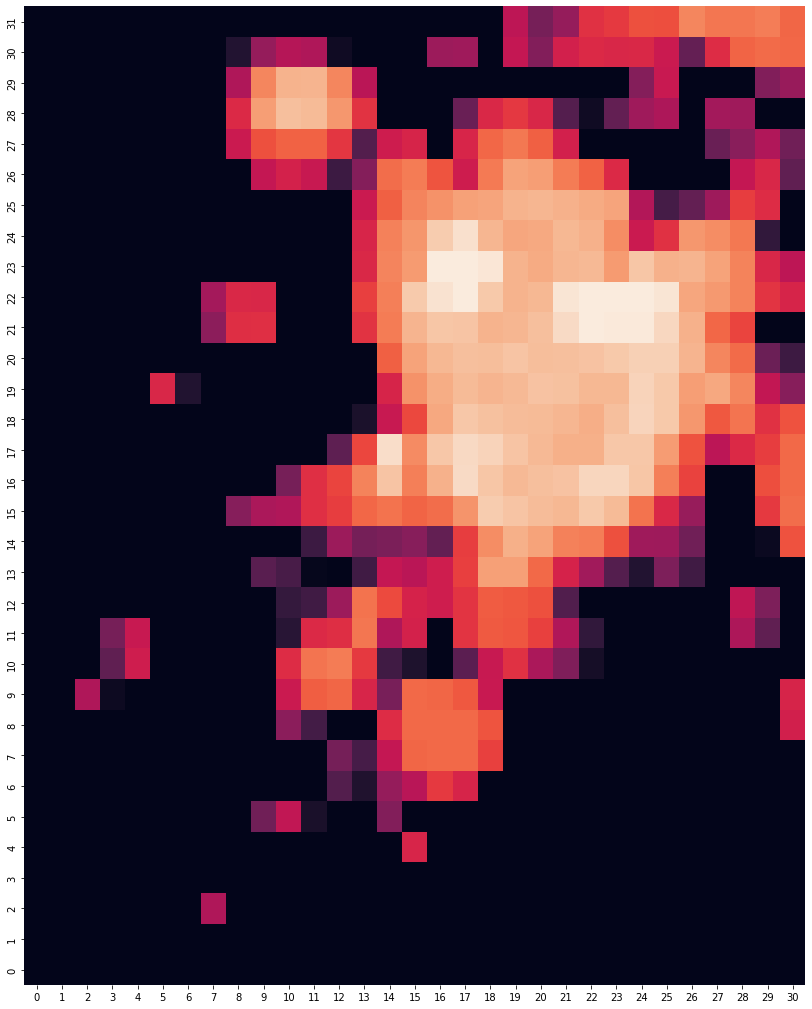

In [12]:
plt.figure(figsize=(14, 18))
sns.heatmap(np.log1p(submatrix), cbar=False, vmin=0, vmax=13)
plt.gca().invert_yaxis()
plt.show()

In [13]:
def plot_density_matrix(matrix):
    matrix = np.array(matrix)
    plt.figure(figsize=(14, 18))
    sns.heatmap(np.log1p(matrix), vmin=0, vmax=14, cbar=False)
    plt.gca().invert_yaxis()
    plt.show()

In [14]:
def plot_ax_density_matrix(ax, matrix):
    matrix = np.array(matrix)
    matrix = np.log1p(matrix)
    sns.heatmap(matrix, ax=ax, vmin=0, vmax=14, cbar=False)
    ax.invert_yaxis()

In [15]:
def plot_2_density_matrixes(m1, m2):
    fig, axs = plt.subplots(1, 2, figsize=(14, 9))
    plot_ax_density_matrix(axs[0], m1)
    plot_ax_density_matrix(axs[1], m2)
    plt.tight_layout()
    plt.show()

In [16]:
def backend_request(min_lat, min_lng, max_lat, max_lng):
    return requests.post(
        'http://host.docker.internal:5000/heatmap/sportzone-density',
        json={
            'geoRect': {
                'minLat': min_lat,
                'minLng': min_lng,
                'maxLat': max_lat,
                'maxLng': max_lng
            },
            'sportzoneIds': sportzones['id'].tolist()
        }
    ).json()

In [17]:
def python_request(min_lat, min_lng, max_lat, max_lng):
    borders = np.load('map-borders.npy')
    matrix_size = select_zoom_level(borders, min_lat, min_lng, max_lat, max_lng)
    print(f'Matrix size: {matrix_size}')
    matrix = np.load(f'matrix-{matrix_size}.npy')
    return get_sportzone_heatmap(((min_lat, min_lng), (max_lat, max_lng)), sportzones['id'], borders, con())

In [20]:
def plot_random_crop():
    borders = np.load('map-borders.npy')
    (min_lat, min_lng), (max_lat, max_lng) = borders
    height = max_lat - min_lat
    width = max_lng - min_lng
    rand = lambda: random.random()
    size = rand() * 0.1
    print(f'Size: {size:.2f}')
    lat_shift = (1 - size) * rand()
    lng_shift = (1 - size) * rand()
    lat1 = min_lat + height * lat_shift
    lng1 = min_lng + width * lng_shift
    lat2 = min_lat + height * (lat_shift + size)
    lng2 = min_lng + width * (lng_shift + size)
    if lat1 > lat2:
        lat1, lat2 = lat2, lat1
    if lng1 > lng2:
        lng1, lng2 = lng2, lng1
    res = backend_request(lat1, lng1, lat2, lng2)
    borders, matrix2 = python_request(lat1, lng1, lat2, lng2)
    print(f"API rect: {res['geoRect']}")
    print(f"Py rect: {borders}")
    plot_2_density_matrixes(res['matrix'], matrix2)

Size: 0.07
Matrix size: 512
API rect: {'minLat': 55.785678172886755, 'minLng': 37.520262681621766, 'maxLat': 55.849344157634505, 'maxLng': 37.61005866630657}
Py rect: ((55.785678172886755, 37.520262681621766), (55.849344157634505, 37.61005866630657))


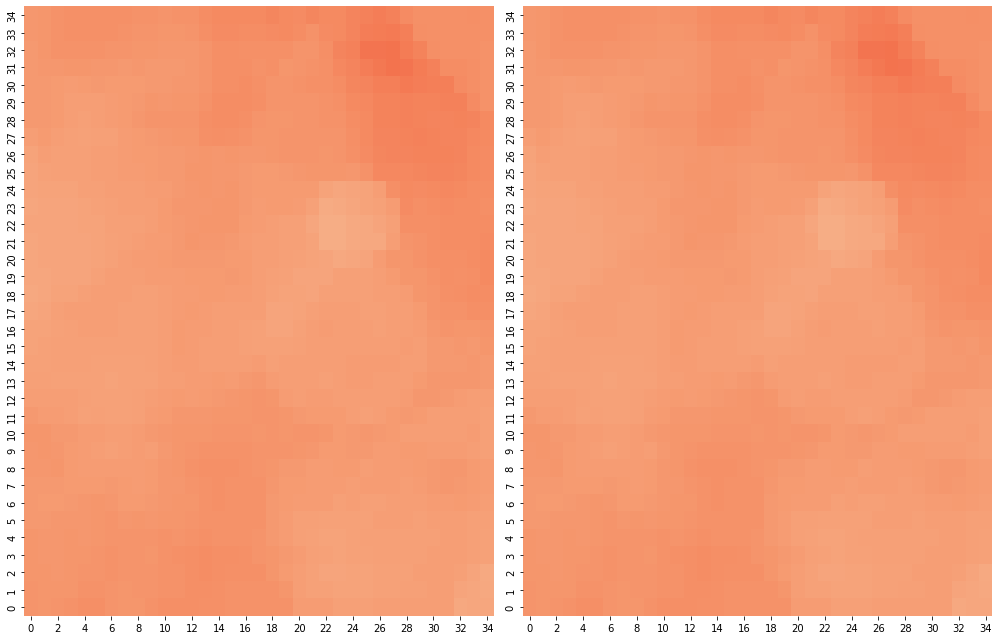

CPU times: user 1.28 s, sys: 331 ms, total: 1.61 s
Wall time: 5.63 s


In [26]:
%%time
plot_random_crop()